# A webscraping and analysis of transistor count

This jupyter notebook takes a look at the [transistor count](https://en.wikipedia.org/wiki/Transistor_count), scrapes the data using beautiful soup and then draw up some graphs based on the data we find in the processor table.

## Imports

In [1]:
import bs4 #beautifulsoup 4
from urllib.request import urlopen as uReq #url open module
from bs4 import BeautifulSoup as soup #beautifulsoup module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re # regex
import os
import math
import random 

%matplotlib inline

## Fetch the page 

In [2]:
base_url = "https://en.wikipedia.org/wiki/Transistor_count"

# Download all 5 pages we want to scrape and dump them to a variable
uClient = uReq(base_url)
page_html = uClient.read()
uClient.close()

## Convert to a soup 

In [3]:
page_soup = soup(page_html)
page_soup

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Transistor count - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Transistor_count","wgTitle":"Transistor count","wgCurRevisionId":923241677,"wgRevisionId":923241677,"wgArticleId":4469365,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All articles with dead external links","Articles with dead external links from May 2019","CS1 German-language sources (de)","Use mdy dates from January 2015","Articles containing potentially dated statements from 2019","All articles containing potentially dated statements","Articles containing potentially dated statements from 2018","Articles containing potentially dated statements from 2016","All accuracy disputes","Articles with disputed statements from August 2019","

## Pick out the first table on the page

We can simply use find to get the table we want since it is the first table on the website.

In [4]:
table = page_soup.find('table', class_="wikitable sortable")
table

<table class="wikitable sortable" style="text-align:left;">
<tbody><tr>
<th><a href="/wiki/Microprocessor" title="Microprocessor">Processor</a>
</th>
<th data-sort-type="number"><a class="mw-redirect" href="/wiki/MOS_transistor" title="MOS transistor">MOS transistor</a> count
</th>
<th>Date of<br/>introduction
</th>
<th>Designer
</th>
<th data-sort-type="number"><a href="/wiki/MOSFET" title="MOSFET">MOS</a><br/><a href="/wiki/Semiconductor_device_fabrication" title="Semiconductor device fabrication">process</a>
</th>
<th data-sort-type="number">Area
</th></tr>
<tr>
<td><a class="mw-redirect" href="/wiki/MP944" title="MP944">MP944</a> (20-bit, <i>6-chip</i>)
</td>
<td><i><b>?</b></i>
</td>
<td>1970<sup class="reference" id="cite_ref-F-14_19-1"><a href="#cite_note-F-14-19">[19]</a></sup><sup class="reference" id="cite_ref-21"><a href="#cite_note-21">[a]</a></sup>
</td>
<td><a href="/wiki/Garrett_AiResearch" title="Garrett AiResearch">Garrett AiResearch</a>
</td>
<td><i><b>?</b></i>
</td>

## Pull out the rows from the table

Each row has 6 columns;

Processor, MOS transistor count, Date of introduction, Designer, MOS Process, Area

We include all the columns since we don't know which ones we might to look at in the data. We do however remove a few rows.

This is accomplished by finding all the tr tags in the table.

### Remove the first row, the table headers 

In [5]:
rows = table.find_all('tr')
print(rows[0])
#The first row is the header so we remove that
rows = rows[1:]

<tr>
<th><a href="/wiki/Microprocessor" title="Microprocessor">Processor</a>
</th>
<th data-sort-type="number"><a class="mw-redirect" href="/wiki/MOS_transistor" title="MOS transistor">MOS transistor</a> count
</th>
<th>Date of<br/>introduction
</th>
<th>Designer
</th>
<th data-sort-type="number"><a href="/wiki/MOSFET" title="MOSFET">MOS</a><br/><a href="/wiki/Semiconductor_device_fabrication" title="Semiconductor device fabrication">process</a>
</th>
<th data-sort-type="number">Area
</th></tr>


In [6]:
rows[0] # Verify that we do not have the header any longer

<tr>
<td><a class="mw-redirect" href="/wiki/MP944" title="MP944">MP944</a> (20-bit, <i>6-chip</i>)
</td>
<td><i><b>?</b></i>
</td>
<td>1970<sup class="reference" id="cite_ref-F-14_19-1"><a href="#cite_note-F-14-19">[19]</a></sup><sup class="reference" id="cite_ref-21"><a href="#cite_note-21">[a]</a></sup>
</td>
<td><a href="/wiki/Garrett_AiResearch" title="Garrett AiResearch">Garrett AiResearch</a>
</td>
<td><i><b>?</b></i>
</td>
<td><i><b>?</b></i>
</td></tr>

We have 188 rows in the table!

In [7]:
len(rows)

188

# Before we start, we can take a look at the table

We can simply look at the table on the website itself. We already notice that there are rows where a portion of the columns we're interested are empty. There are also a few anomalies or "redundant" data. Almost all of these will simply be converted to a numpy NAN when we've cleaned them however there is one row which we outright delete.

This row is the secondary row for the TSMC processor. it's a row which only has the last two columns of the table. Since it only has a secondary manufacterer it has less statistical value.

## Delete the anomaly row

We can see that it only has 2 td's that correspond to the last two columns of the table.

In [8]:
rows[143]

<tr>
<td>16 nm<br/>(<a href="/wiki/TSMC" title="TSMC">TSMC</a>)
</td>
<td>104.5 mm²<br/>(<a href="/wiki/TSMC" title="TSMC">TSMC</a>)
</td></tr>

***Only delete the row the first time this code block is run to not remove unnecessary data***

In [9]:
del_row = rows[143].find('a').text
if (del_row == 'TSMC'):
    del rows[143]

## Functions for cleaning up the data we want to pick out

#### Clean a td.

Makes use of the .extract() function in beautiful soup to remove html tags that only contain redundant information

In [10]:
def td_cleaner(td):
    """Removes unwanted HTML tags from a beutiful soup HTML tag/object
    
    Removes i, sup, small, span tags"""
    unwanted_tags = ['i', 'sup', 'small', 'span' ]
    for tag in unwanted_tags:
        for unwanted in td.find_all(tag):
            unwanted.extract()
    return td

#### Clean a string

This function is a simple replacer function which removes a few annoying characters from the text we send into it.

In [11]:
def string_cleaner(text):
    """Take a string and replace multiple characters it contains
    
    Replaces 'nm', ',', '+'"""
    text = text.replace('nm','')
    text = text.replace(',','')
    text = text.replace('+','')
    return text

#### Run a couple regex subs on a string

We remove all parenthesis and brackets as well as everything within the characters. The website itself only have parenthesis which had to be removed.

We imported re earlier and use re.sub to replace the characters that match.

In [12]:
def regex_clean_and_strip(text):
    """Takes a string and runs a re.sub to find and remove everything contained in a parenthesis or brackets"""
    # Remove everything inside a parenthesis
    text = re.sub('\((.*)\)', '', text)
    # Remove everything inside brackets
    text = re.sub('\[(.*)\]', '', text)
    return text.strip()

### Clean the values in a row

We send in a beautiful soup tr to the two following functions. One is for the processor name and the second is for number values such as the transistor count, intro year and MOS process.

Both of these make use of the three previous functions to appropriately clean the row to our needs. The processor name is returned as a string and the numbers are returned as floats.

***The processor name doesn't need to have more cleaning that just removing the parenthesis following the name of the processor***

In [13]:
def parse_processor_name(row):
    """Takes a row from a table, picks out the first td and cleans the string inside id. This function retuns a string."""
    td = row.find_all('td')[0]
    td = td_cleaner(td)
    name = regex_clean_and_strip(td.text)
    try:
        return name
    except:
        return np.nan

***The numbers need to be cleaned more thoroughly so we have to run all 3 cleaner functions on them***

In [14]:
def parse_column_to_float(row, col):
    """Take a row and a column from a table, pick out the td at the specified column and then clean that data.
    
    Returns a float."""
    td = row.find_all('td')[col]
    td = td_cleaner(td)
    num = string_cleaner(td.text)
    num = regex_clean_and_strip(num)
    try:
        return float(num)
    except:
        return np.nan

### Pick out the year

The years are the only piece of clean data in the table so we can simply pick out the correct column (td) and take the first 4 letters of the text.

In [15]:
def parse_introduction_date(row):
    tds = row.find_all('td')
    return int(tds[2].text[0:4])

## Define a dataframe for the data we are parsing

We make a pandas DataFrame with the columns we will need later.
* Processor name
* Transistor count
* Introduction year
* Production accuracy (MOS process)

In [16]:
column_names = ['Processor', 'Count', 'Year', 'Accuracy']
df = pd.DataFrame(columns=column_names)
df.head()

,Processor,Count,Year,Accuracy


***Convert the columns to an appropriate data type using pandas astype()***

In [17]:
df.Count = df.Count.astype(float)
df.Year = df.Year.astype(int)
df.Accuracy = df.Accuracy.astype(int)

df.dtypes

Processor     object
Count        float64
Year           int32
Accuracy       int32
dtype: object

## Main function to create a dataFrame from the table

We loop through each row we found in the table we scraped. We then make use of the 3 parse functions we created earlier to clean each rows data before we finally send them into our newly created DataFrame.


In [18]:
i = 0
for row in rows:
    # Parse processor name
    name = parse_processor_name(row)
    # Parse Transistor count
    count = parse_column_to_float(row, 1)
    # Parse Introduction date
    date = parse_introduction_date(row)
    # Parse Production accuracy (MOS Process)
    accuracy = parse_column_to_float(row, 4)
    df.loc[i] = name, count, date, accuracy
    i += 1

## Processor count per decade

Draw a barchart showing each decade and how many processors were made during them.

We can use the original dataset since we are only interested in the total amount of processors per year, even though they may not have all the other data.

***We can use group by and divide the year and multiply by 10. We make use of the fact that they are integers***

Example: 1976 / 10 = 197 -> 197 * 10 = 1970

***This dataframe is used to draw the bar chart***

In [19]:
y = df.groupby(df.Year//10*10).count()[['Count']]
y.head()

,Count
Year,
1970,21
1980,25
1990,26
2000,37
2010,71


## Draw the bar chart

We use the dataFrame **y** created above. Decades are on the x axis and the amount of processors produced per decade on the y axis.

zorder is used to hide the grid behind the bars to more easily be able to connect the bar height to the labeling on the y axis.

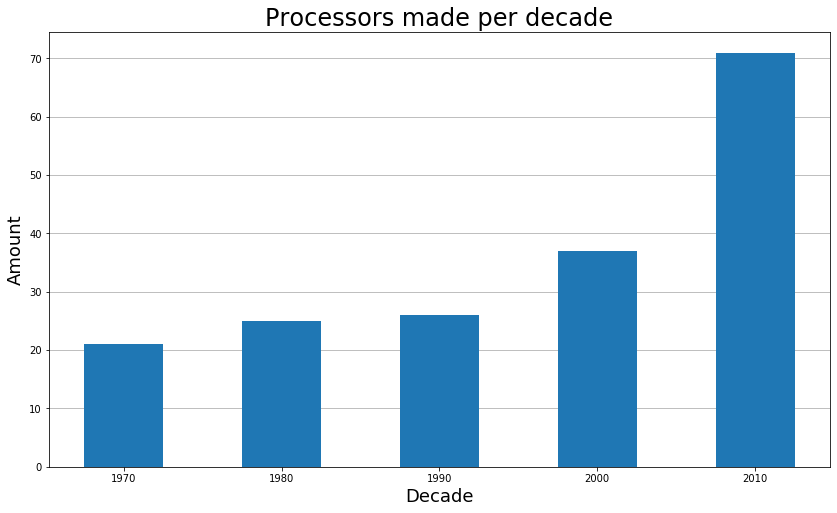

In [20]:
plt.figure(figsize=(14,8))

plt.bar(y.index.values, y.Count, width=5, zorder=3)

plt.title('Processors made per decade', fontsize=24)
plt.grid(axis='y', zorder=0)
plt.xlabel('Decade', fontsize=18)
plt.xticks(y.index.values)

plt.ylabel('Amount', fontsize=18)

plt.show()

## Improvements to production accuracy

Draw a line graph to show how the production accuracy improves over time.

Here we make use of the data without NAN values since those don't have any value in this dataset.

***Since each year has multiple data points, we only make use of one processor per year to draw the data. We chose to use the smallest MOS process in each year since that most accurately explains the potential production acuracy that year.***

#### Create a minimi  dataFrame, grouped by the year and taking the min value

In [21]:
minimi = df.dropna().groupby(df.Year).min()
minimi.head()

,Processor,Count,Year,Accuracy
Year,,,,
1971,Intel 4004,2250.0,1971,10000.0
1972,Intel 8008,3500.0,1972,10000.0
1973,NEC μCOM-4,2500.0,1973,6000.0
1974,Intel 4040,3000.0,1974,6000.0
1975,MOS Technology 6502,4528.0,1975,8000.0


### Create a plot of with the dataPoints from minimi

We chose to make the dotted line a lighter color since it is only a visualization of our data, while the blue dots are the actual data points. 

We make a large enough graph using figsize.
We set a descriptive title and labels for the axes.

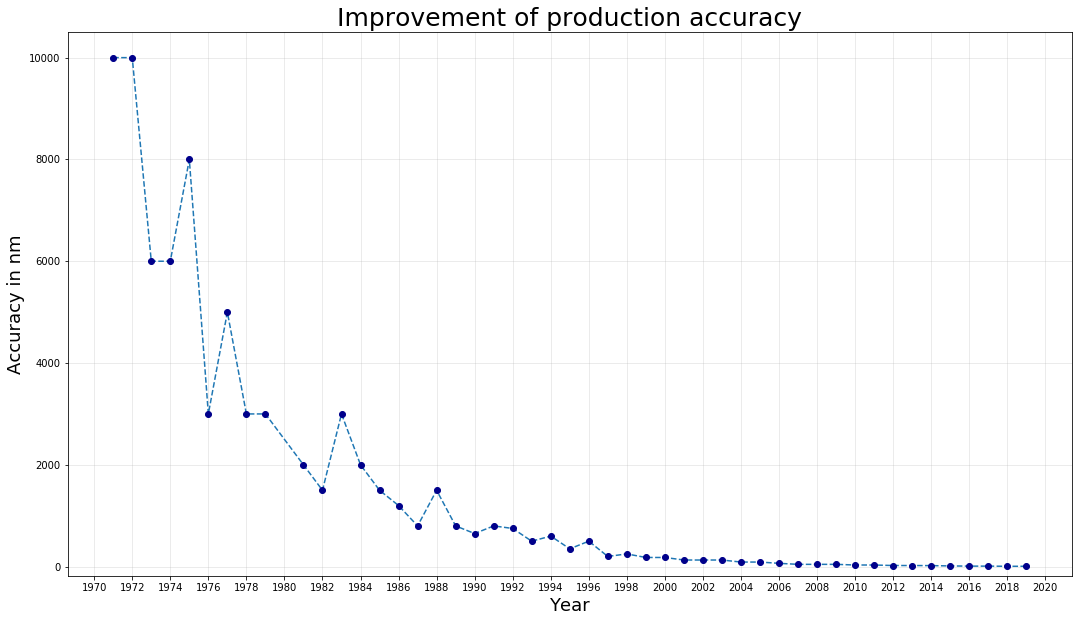

In [22]:
plt.figure(figsize=(18,10))
plt.plot(minimi.index.values, minimi.Accuracy, marker='o', mfc='darkblue', mec='darkblue', linestyle='--')

plt.title('Improvement of production accuracy', fontsize=25)

plt.xlabel('Year', fontsize=18)
plt.xticks(np.arange(1970, 2022, step=2))

plt.ylabel('Accuracy in nm', fontsize=18)
plt.yticks(np.arange(0, 12000, step=2000))
plt.ylim(bottom=-180) # Pull the 0 closer to the bottom of the y-axis

plt.grid(alpha=0.3)
plt.show()

## Transistor count and moores law

Here we will take the data we created and do two things. We will create a scatter plot of the recorded data for transistor counts. The second thing is we are going to calculate a projected line based on Moore's law on the first value in our dataset.

### Calculate a Moore's law dataset

We take the not NAN values from our original dataset and take the first value. I personally wanted the line to extend past the first point of data so i divide that value by two. This won't change the line since we still we simply counteract this division on our first multiplication.

***We create a list of these values. Each new value is (2 * x), where x is the last value in the list. This value is then appended to the list.***

In [23]:
moores_law = df.dropna()[['Count','Year']]

i = 0
start_value2 = moores_law['Count'].iloc[0] / 2
moores_list = [start_value2]
while i < 26:
    moores_list.append(moores_list[i] * 2)
    i +=1 

### Function to create an annotation

The function takes in a number, and this number is an index found in the df.dropna() dataFrame. 
We need the name, year, and count from the dataframe.

The annotate requires a string for the name, as well as coordinates for the string (xytext), as well as the coordinates for which point it will annotate (xy). We then draw an arrow from the text to the point using arrowprops.

The xytext is using an offset. Since we will have a lot of whitespace in our graph, the offset is to the left when our datapoint is on the topright of our graph and the offset is to the right if we are on the bottomleft of our graph.

In [24]:
def annotate_random(num):
    """Take a number as an index and create an annotation for a plt plot. Uses an global df.dropna() where the index is used."""
    name = df.dropna().Processor.iloc[num]
    year = df.dropna().Year.iloc[num]
    count = df.dropna().Count.iloc[num]
    ypos = count
    xpos = year
    offset = 15
    if (year > 1995):
        xpos -= offset
    else:
        xpos += offset
    return plt.annotate(name, xy=(year,count), xytext=(xpos, ypos), arrowprops=dict(arrowstyle="-"))

### Draw all the data 

We make use the the Moore's law generated list and the original df dataFrame to generate our two plots. We create one scatter plot using our actual data points we got from the wikipedia table. Our Moore's law list is used to draw a line showing how the transistor count is expected to look like using the first value from our df dataFrame. 

Our Moore's law list has the same shape(length) as the np.arange generate years. Since Moore's law calculates that each two years the value is doubled. Since we did that calculation to create the list, we simply need to make sure to assign the first value to our designated starting year, and the next value to 2 years from then and so on.

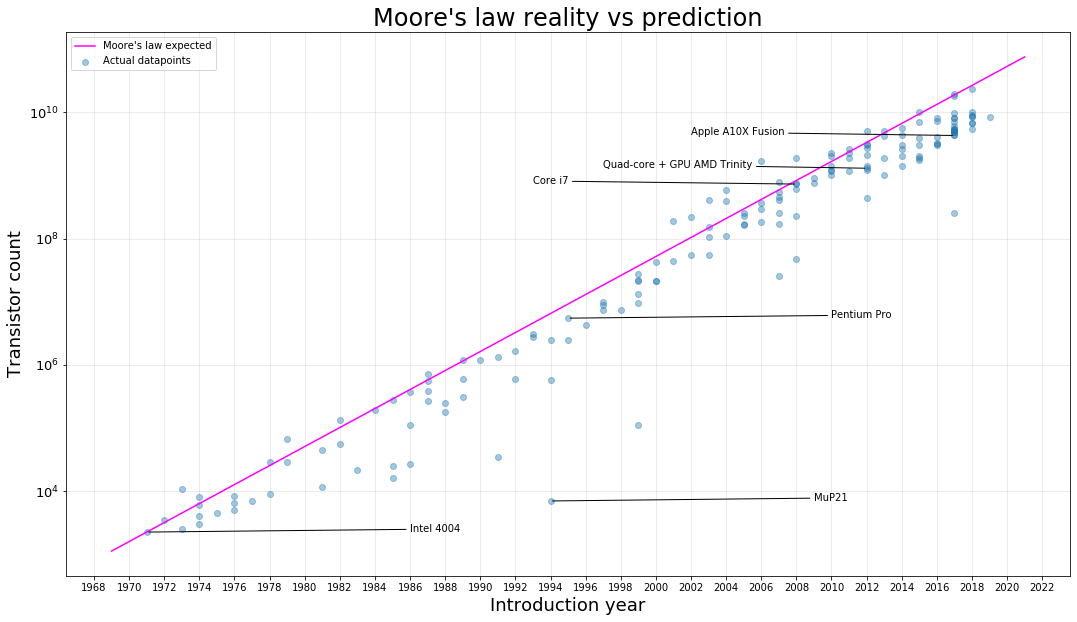

In [25]:
# Create a list of points we want to annotate
rand_list = [0,46,49,91,random.randint(100,120),random.randint(140,160)]

plt.figure(figsize=(18,10))

# X point is year, y point is transistor count
plt.scatter(df.dropna().Year, df.dropna().Count, alpha='0.4', label='Actual datapoints', zorder=3)
# X point is the year, y is the Moore's law generated list
plt.plot(np.arange(1969, 2023, step=2), moores_list, color='magenta', label="Moore's law expected", zorder=3)

plt.xticks(np.arange(1968, 2024, step=2))
plt.yticks(fontsize=13)
plt.yscale('log')

plt.title("Moore's law reality vs prediction", fontsize=24)
plt.ylabel('Transistor count', fontsize=18)
plt.xlabel('Introduction year', fontsize=18)

# Use our generated list to create annotations
for num in rand_list:
    annotate_random(num)

plt.grid(zorder=0, alpha=0.3)
plt.legend()
plt.show()

# Our annotations:

* Intel 4004 - The first single-chip microprocessor (and first one known by the public)
* MuP21 - An outlier
* Pentium Pro - The first processor to reach the [teraFLOPS](https://en.wikipedia.org/wiki/FLOPS) performance mark
* Core i7 - Start of the Core I7 series
* 2 random processors from 2010 and later
